# Rescale and Calculate Average

Tasks:

1. Rescale each Standard Error of Prediction (SEP) raster to [0 - 1] in the last 5 years (2015 - 2019)
2. Calculate the average of rescaled SEP rasters in each managed area and parameter.
3. Export the average rasters to tif files (one file for each parameter in each managed area). Total 5 parameters * 5 managed areas=25 maps

4. For Charlotte Harbor area,create an average rescaled SEP raster for each parameter and in each season.  Total 5 parameters * 4 seasons = 20 maps.

* [1.Data Preprocess](#reg_preprocessing)
* [2. Rescale Standard Error Prediction](#reg_rescale)
* [3. Rescaled Standard Error Prediction Results](#reg_rescale_results)
    * [3.1 Charlotte Harbor](#reg_result_sep_ch)
    * [3.2 Estero Bay](#reg_result_sep_eb)
    * [3.3 Big Bend](#reg_result_sep_bb)
    * [3.4 Biscayne Bay Aquatic Preserve](#reg_result_sep_bbay)
    * [3.5 Guana Tolomato](#reg_result_sep_gtm)
* [4. Check the Original Tif Files](#reg_check_file)
    * [4.1 Charlotte Harbor](#reg_check_file_ch)
    * [4.2 Estero Bay](#reg_check_file_eb)
    * [4.3 Big Bend](#reg_check_file_bb)
    * [4.4 Biscayne Bay Aquatic Preserve](#reg_check_file_bbay)
    * [4.5 Guana Tolomato](#reg_check_file_gtm)
* [5. Rescaled Updated Standard Error Prediction Results](#reg_rescale_up_results)
    * [5.1 Charlotte Harbor](#reg_result_up_sep_ch)
    * [5.2 Estero Bay](#reg_result_up_sep_eb)
    * [5.3 Big Bend](#reg_result_up_sep_bb)
    * [5.4 Biscayne Bay Aquatic Preserve](#reg_check_file_bbay)
    * [5.5 Guana Tolomato](#reg_result_up_sep_gtm)
* [6. Calculate and Plot Average Rescaled SEP](#reg_calculate_average)
    * [6.1 Charlotte Harbor](#reg_avg_rescale_sep_ch)
    * [6.2 Estero Bay](#reg_avg_rescale_sep_eb)
    * [6.3 Big Bend](#reg_avg_rescale_sep_bb)
    * [6.4 Biscayne Bay Aquatic Preserve](#reg_avg_rescale_sep_bbay)
    * [6.5 Guana Tolomato](#reg_avg_rescale_sep_gtm)
* [7. Calculate Average Rescaled SEP by Season](#reg_calculate_average_season)
    * [7.1 Charlotte Harbor](#reg_avg_rescale_sep_season_ch)

In [1]:
import os
import glob
import re
import rasterio
import numpy as np
from rasterio.enums import Resampling
from rasterio.warp import calculate_default_transform, reproject, Resampling
from collections import defaultdict
import numpy.ma as ma
import pandas as pd
import geopandas as gpd
from rasterio.features import shapes
from shapely.geometry import shape, Polygon, box
from rasterio.plot import show
import matplotlib.pyplot as plt
import contextily as cx
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec

# 1. Data Preprocessing <a class="anchor" id="reg_preprocessing"></a>
Define the standard error prediction folders

In [2]:
path = '/Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/'
eps_path = path+'standard_error_prediction-selected/'
rescale_path_CH = eps_path + r"Rescaled_Charlotte Harbor"
rescale_path_EB = eps_path + r"Rescaled_Estero Bay"
rescale_path_BB = eps_path + r"Rescaled_Big Bend"
rescale_path_BBay = eps_path + r"Rescaled_Biscayne Bay"
rescale_path_GTM = eps_path + r"Rescaled_GTM Reserve"

# Store updated rescale files
rescale_Uppath_CH = eps_path + r"Rescaled_Update_Charlotte Harbor"
rescale_Uppath_EB = eps_path + r"Rescaled_Update_Estero Bay"
rescale_Uppath_BB = eps_path + r"Rescaled_Update_Big Bend"
rescale_Uppath_BBay= eps_path + r"Rescaled_Update_Biscayne Bay"
rescale_Uppath_GTM= eps_path + r"Rescaled_Update_GTM Reserve"

# Store average tif files
avg_tif_ch = eps_path + r"Average_sep_ch"
avg_tif_eb = eps_path + r"Average_sep_eb"
avg_tif_bb = eps_path + r"Average_sep_bb"
avg_tif_bbay = eps_path + r"Average_sep_bbay"
avg_tif_gtm = eps_path + r"Average_sep_gtm"

#Store average tif files in Charlotte Harbor by seasons
avg_tif_ch_season = eps_path + r"Average_sep_ch_season"

gis_path = path+'GIS_data/'
boundary = gis_path + r"ORCP_Managed_Areas_Oct2021.shp"

# 2. Rescale Standard Error Prediction <a class="anchor" id="reg_rescale"></a>
Function to rescale SEP

In [3]:
def rescale_tif_files(folder_path, subfolder, year_start, year_end, output_folder_path):
    # find subfolder
    specific_path = os.path.join(folder_path, subfolder)
    
    # create output folder if not exists
    if not os.path.exists(output_folder_path):
        os.makedirs(output_folder_path)
    
    # find tif
    tif_files = glob.glob(os.path.join(specific_path, '*.tif'))
    
    # generate list of years
    year_list = list(range(year_start, year_end + 1))
    
    # filter time period
    tif_files_filtered = [f for f in tif_files if int(re.search(r'\d{4}', os.path.basename(f)).group()) in year_list]
    
    # process filtered tif
    for file in tif_files_filtered:
        with rasterio.open(file) as src:
            # read tif
            data = src.read(1).astype(np.float64)

            # mask nodata
            masked_data = np.ma.masked_equal(data, src.nodata)

            # calculate min and max of valid data
            valid_min = masked_data.min()
            valid_max = masked_data.max()

            # avoid division by zero
            if valid_max != valid_min:
                rescaled_data = (masked_data - valid_min) / (valid_max - valid_min)
            else:
                rescaled_data = np.zeros_like(masked_data)

            # save rescaled tif file
            new_file_name = f'rescaled_{os.path.basename(file)}'
            new_file_path = os.path.join(output_folder_path, new_file_name)
            with rasterio.open(new_file_path, 'w', driver='GTiff',
                            height=rescaled_data.shape[0], 
                            width=rescaled_data.shape[1], 
                            count=1, dtype='float32',
                            crs=src.crs, 
                            transform=src.transform,
                            nodata=src.nodata) as new_dataset:
                new_dataset.write(rescaled_data.filled(src.nodata).astype('float32'), 1)

Function to empty folder

In [4]:
def delete_all_files(folder_path):
    file_list = os.listdir(folder_path)
    for file_name in file_list:
        file_path = os.path.join(folder_path, file_name)
        if os.path.isfile(file_path):
            os.remove(file_path)

# 3. Rescaled Standard Error Prediction Results <a class="anchor" id="reg_rescale_results"></a>
## 3.1 Charlotte Harbor <a class="anchor" id="reg_result_sep_ch"></a>

In [5]:
delete_all_files(rescale_path_CH)

In [6]:
rescale_tif_files(eps_path,'Charlotte Harbor', 2015, 2019, rescale_path_CH)

## 3.2 Estero Bay  <a class="anchor" id="reg_result_sep_eb"></a>

In [7]:
delete_all_files(rescale_path_EB)

In [8]:
rescale_tif_files(eps_path,'Estero Bay', 2015, 2019, rescale_path_EB)

##  3.3 Big Bend <a class="anchor" id="reg_result_sep_bb"></a>

In [9]:
delete_all_files(rescale_path_BB)

In [10]:
rescale_tif_files(eps_path,'Big Bend', 2015, 2019, rescale_path_BB)

## 3.4 Biscayne Bay <a class="anchor" id="reg_result_sep_bbay"></a>

In [11]:
delete_all_files(rescale_path_BBay)

In [12]:
rescale_tif_files(eps_path,'Biscayne Bay', 2015, 2019, rescale_path_BBay)

## 3.5 Guana Tolomato <a class="anchor" id="reg_result_sep_gtm"></a>

In [13]:
delete_all_files(rescale_path_GTM)

In [14]:
rescale_tif_files(eps_path,'GTM Reserve', 2015, 2019, rescale_path_GTM)

Check if a given TIFF file is a GeoTIFF.

In [15]:
def is_geotiff(filename):
    try:
        with rasterio.open(filename) as ds:
            return ds.crs is not None
    except rasterio.errors.RasterioIOError:
        return False

In [16]:
geotiffs_folder = avg_tif_ch

for filename in os.listdir(geotiffs_folder):
    file_path = os.path.join(geotiffs_folder, filename)
    if filename.endswith(".tif") and is_geotiff(file_path):
        # This is a GeoTIFF, process it.
        print(f"{file_path} is a GeoTIFF file.")

/Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/standard_error_prediction-selected/Average_sep_ch/avg_SD.tif is a GeoTIFF file.
/Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/standard_error_prediction-selected/Average_sep_ch/avg_DO.tif is a GeoTIFF file.
/Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/standard_error_prediction-selected/Average_sep_ch/avg_T.tif is a GeoTIFF file.
/Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/standard_error_prediction-selected/Average_sep_ch/avg_TN.tif is a GeoTIFF file.
/Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/standard_error_prediction-selected/Average_sep_ch/avg_S.tif is a GeoTIFF file.


In [17]:
test = avg_tif_ch + r"/avg_TN.tif"

with rasterio.open(test) as src:
    crs = src.crs
    print(crs)

EPSG:3086


# 4. Check the Original Tif Files <a class="anchor" id="reg_check_file"></a>

Note: As the average calculation consistently produced results outside the study area, I have implemented a method to validate the shape of the raster data.

Function to check the original tif file

In [18]:
def group_tif_by_shapes(folder_path):
    # Get all .tif files in the directory
    tif_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.endswith('.tif')]
    
    # If no .tif files found, return
    if not tif_files:
        print("No .tif files found in the directory.")
        return
    
    # Initialize a dictionary to group files by their shapes
    shape_dict = defaultdict(list)
    
    # Check the shapes of all files
    for tif_file in tif_files:
        with rasterio.open(tif_file) as src:
            shape_dict[src.shape].append(tif_file)
    
    # Print the results
    for i, (shape, files) in enumerate(shape_dict.items(), 1):
        print(f"Group {i} - Shape: {shape} - Files: {len(files)}")
        for file in files:
            print(f"  {file}")
        print("-" * 40)

Function to check the Geotiff files are in the correct study area

In [19]:
def check_tif_within_study_area(polygon_folder_path, target_subfolder, study_area_shp_path, study_area_name, start_year, end_year):
    # Load the shapefile
    shapefile = gpd.read_file(study_area_shp_path)

    # Get the polygon that matches the input study_area_name
    polygon = shapefile[shapefile['MA_Name'] == study_area_name].geometry

    # If no corresponding polygon is found, return
    if polygon.empty:
        print(f"No polygon found for study area: {study_area_name}")
        return

    # Check each tif file
    target_folder = os.path.join(polygon_folder_path, target_subfolder)
    tif_files = [f for f in os.listdir(target_folder) if f.endswith('.tif')]

    # Filter tif files by year range
    tif_files = [f for f in tif_files if start_year <= int(f[:4]) <= end_year]

    # Sort tif files by year
    tif_files_sorted = sorted(tif_files, key=lambda f: int(f[:4]))

    # To track if any file is out of its boundary
    out_of_boundary = False

    for tif_file in tif_files_sorted:
        tif_path = os.path.join(target_folder, tif_file)

        # Open the tif file and get its boundary
        with rasterio.open(tif_path) as src:
            bounds = src.bounds

        # Create a bounding box for the tif file
        tif_box = box(bounds[0], bounds[1], bounds[2], bounds[3])

        # Check whether the bounding box of the tif file intersects with the polygon
        if not polygon.intersects(tif_box).any():
            print(f"WARNING: {tif_file} in study area {study_area_name} is out of its boundary!")
            out_of_boundary = True

    if not out_of_boundary:
        print(f"All tif files are within the boundary of study area {study_area_name}.")

## 4.1 Charlotte Harbor <a class="anchor" id="reg_check_file_ch"></a>

After checking, the rescaled_2019Summer_S is not in Charlotte Harbor but instead in Estero Bay.   
The original tif file also needs to move to the right folder.

In [20]:
group_tif_by_shapes(rescale_path_CH)

Group 1 - Shape: (1122, 986) - Files: 64
  /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/standard_error_prediction-selected/Rescaled_Charlotte Harbor/rescaled_2017Fall_SD.tif
  /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/standard_error_prediction-selected/Rescaled_Charlotte Harbor/rescaled_2015Spring_S.tif
  /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/standard_error_prediction-selected/Rescaled_Charlotte Harbor/rescaled_2019Spring_T.tif
  /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/standard_error_prediction-selected/Rescaled_Charlotte Harbor/rescaled_2017Fall_S.tif
  /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/standard_error_prediction-selected/Rescaled_Charlotte Harbor/rescaled_2016Fall_TN.tif
  /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/standard_error_prediction-selected/Rescaled_Charlotte Harbor/rescaled_2017Fall_DO.tif
  /Users/cong/Downloads/Wate

In [21]:
check_tif_within_study_area(eps_path, 'Charlotte Harbor', boundary, 'Gasparilla Sound-Charlotte Harbor', 2015, 2019)

## 4.2 Estero Bay  <a class="anchor" id="reg_check_file_eb"></a>

After checking, the rescaled_2015Spring_S.tif is not in Estero Bay but instead in Charlotte Harbor.  
The rescaled_2017Summer_S.tif is not in Estero Bay but instead in Charlotte Harbor.  
The rescaled_2019Spring_S.tif is not in Estero Bay but instead in Charlotte Harbor.  
The original tif file also needs to move to the right folder.

In [22]:
group_tif_by_shapes(rescale_path_EB)

Group 1 - Shape: (1122, 986) - Files: 3
  /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/standard_error_prediction-selected/Rescaled_Estero Bay/rescaled_2015Spring_S.tif
  /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/standard_error_prediction-selected/Rescaled_Estero Bay/rescaled_2019Spring_S.tif
  /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/standard_error_prediction-selected/Rescaled_Estero Bay/rescaled_2017Summer_S.tif
----------------------------------------
Group 2 - Shape: (552, 446) - Files: 54
  /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/standard_error_prediction-selected/Rescaled_Estero Bay/rescaled_2017Summer_TN.tif
  /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/standard_error_prediction-selected/Rescaled_Estero Bay/rescaled_2019Spring_T.tif
  /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/standard_error_prediction-selected/Rescaled_Estero Bay/resc

In [23]:
check_tif_within_study_area(eps_path, 'Estero Bay', boundary, 'Estero Bay', 2015, 2019)

## 4.3 Big Bend <a class="anchor" id="reg_check_file_bb"></a>

For big bend, there are no wrong files in the folder.

In [24]:
group_tif_by_shapes(rescale_path_BB)

Group 1 - Shape: (5048, 5122) - Files: 24
  /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/standard_error_prediction-selected/Rescaled_Big Bend/rescaled_2015Spring_S.tif
  /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/standard_error_prediction-selected/Rescaled_Big Bend/rescaled_2019Summer_S.tif
  /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/standard_error_prediction-selected/Rescaled_Big Bend/rescaled_2019Summer_DO.tif
  /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/standard_error_prediction-selected/Rescaled_Big Bend/rescaled_2015Winter_DO.tif
  /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/standard_error_prediction-selected/Rescaled_Big Bend/rescaled_2019Spring_S.tif
  /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/standard_error_prediction-selected/Rescaled_Big Bend/rescaled_2015Summer_S.tif
  /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected

In [25]:
check_tif_within_study_area(eps_path, 'Big Bend', boundary, 'Big Bend Seagrasses', 2015, 2019)

All tif files are within the boundary of study area Big Bend Seagrasses.


## 4.4 Biscayne Bay <a class="anchor" id="reg_check_file_bbay"></a>

After checking, the rescaled_2019Winter_S.tif is not in Biscayne Bay but instead in Estero Bay. The original tif file also needs to move to the right folder.

In [26]:
group_tif_by_shapes(rescale_path_BBay)

Group 1 - Shape: (2548, 826) - Files: 15
  /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/standard_error_prediction-selected/Rescaled_Biscayne Bay/rescaled_2019Summer_SD.tif
  /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/standard_error_prediction-selected/Rescaled_Biscayne Bay/rescaled_2019Spring_T.tif
  /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/standard_error_prediction-selected/Rescaled_Biscayne Bay/rescaled_2019Summer_S.tif
  /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/standard_error_prediction-selected/Rescaled_Biscayne Bay/rescaled_2019Summer_DO.tif
  /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/standard_error_prediction-selected/Rescaled_Biscayne Bay/rescaled_2019Spring_S.tif
  /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/standard_error_prediction-selected/Rescaled_Biscayne Bay/rescaled_2019Summer_T.tif
  /Users/cong/Downloads/WaterQualityProject/S

In [27]:
check_tif_within_study_area(eps_path, 'Biscayne Bay', boundary, 'Biscayne Bay', 2015, 2019)

## 4.5 Guana Tolomato <a class="anchor" id="reg_check_file_gtm"></a>

After checking, the rescaled_2019Summer_S.tif is not in GTM Reserve but instead in Big Bend.  
The rescaled_2019Spring_S.tif is not in GTM Reserve but instead in Big Bend.  
The original tif file also needs to move to the right folder.

In [28]:
group_tif_by_shapes(rescale_path_GTM)

Group 1 - Shape: (2065, 655) - Files: 44
  /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/standard_error_prediction-selected/Rescaled_GTM Reserve/rescaled_2015Spring_S.tif
  /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/standard_error_prediction-selected/Rescaled_GTM Reserve/rescaled_2017Fall_S.tif
  /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/standard_error_prediction-selected/Rescaled_GTM Reserve/rescaled_2015Winter_DO.tif
  /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/standard_error_prediction-selected/Rescaled_GTM Reserve/rescaled_2017Fall_DO.tif
  /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/standard_error_prediction-selected/Rescaled_GTM Reserve/rescaled_2015Spring_T.tif
  /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/standard_error_prediction-selected/Rescaled_GTM Reserve/rescaled_2015Summer_S.tif
  /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_P

In [29]:
check_tif_within_study_area(eps_path, 'GTM Reserve', boundary, 'Guana Tolomato Matanzas NERR', 2015, 2019)

# 5. Rescaled Updated Standard Error Prediction Results <a class="anchor" id="reg_rescale_up_results"></a>
## 5.1 Charlotte Harbor <a class="anchor" id="reg_result_up_sep_ch"></a>

In [30]:
delete_all_files(rescale_Uppath_CH)

In [31]:
rescale_tif_files(eps_path,'Updated_Charlotte Harbor', 2015, 2019, rescale_Uppath_CH)

## 5.2 Estero Bay  <a class="anchor" id="reg_result_up_sep_eb"></a>

In [32]:
delete_all_files(rescale_Uppath_EB)

In [33]:
rescale_tif_files(eps_path,'Updated_Estero Bay', 2015, 2019, rescale_Uppath_EB)

##  5.3 Big Bend <a class="anchor" id="reg_result_up_sep_bb"></a>

In [34]:
delete_all_files(rescale_Uppath_BB)

In [35]:
rescale_tif_files(eps_path,'Updated_Big Bend', 2015, 2019, rescale_Uppath_BB)

## 5.4 Biscayne Bay <a class="anchor" id="reg_result_up_sep_bbay"></a>

In [36]:
delete_all_files(rescale_Uppath_BBay)

In [37]:
rescale_tif_files(eps_path,'Updated_Biscayne Bay', 2015, 2019, rescale_Uppath_BBay)

## 5.5 Guana Tolomato <a class="anchor" id="reg_result_up_sep_gtm"></a>

In [38]:
delete_all_files(rescale_Uppath_GTM)

In [39]:
rescale_tif_files(eps_path,'Updated_GTM Reserve', 2015, 2019, rescale_Uppath_GTM)

Function to count how many parameters in specific years are used to calculate the average maps

In [40]:
# def count_files_by_year_and_parameter(folder_path):
#     all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.endswith('.tif')]
    
#     file_counts = {} 
    
#     for file in all_files:
#         filename = os.path.basename(file)
#         parts = filename.split('_')
#         year = parts[1][:4]
#         parameter = parts[2]
        
#         if year not in file_counts:
#             file_counts[year] = {}
        
#         if parameter in file_counts[year]:
#             file_counts[year][parameter] += 1
#         else:
#             file_counts[year][parameter] = 1
    
#     return file_counts

# file_counts = count_files_by_year_and_parameter(rescale_Uppath_EB)

# for year in sorted(file_counts.keys()):
#     print(f"Year: {year}")
#     for parameter, count in file_counts[year].items():
#         print(f"Parameter: {parameter}, Count: {count}")

# 6. Calculate and Plot Average Rescaled SEP <a class="anchor" id="reg_calculate_plot_average"></a>

In [41]:
def calculate_average_tif(folder_path, output_folder_path):
    # Get all files in the directory
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.endswith('.tif')]
    
    # Get unique parameters
    parameters = set([os.path.splitext(os.path.basename(f).split('_')[2])[0] for f in all_files])  # Remove the .tif extension from param
    
    for param in parameters:
        print(f"Processing parameter: {param}")
        
        # Get files for this parameter
        param_files = [f for f in all_files if os.path.splitext(os.path.basename(f).split('_')[2])[0] == param]  # Remove the .tif extension from param
        num_files = len(param_files)
        print(f"Found {num_files} files for parameter {param}")
        
        # Read first file to get metadata
        with rasterio.open(param_files[0]) as src0:
            meta = src0.meta
            data_shape = src0.shape
            nodata = src0.nodata
        
        # Initialize sum data and count
        sum_data = ma.zeros(data_shape, dtype=np.float64)
        count = ma.zeros(data_shape, dtype=np.uint16)
        
        # Read and accumulate data
        for file in param_files:
            with rasterio.open(file) as src:
                # Check if data shape is consistent with the first file
                if src.shape != data_shape:
                    print(f"Skipping file {file} due to inconsistent shape.")
                    continue

                # Read data and adjust size if necessary
                data = src.read(1).astype(np.float64)

                # Mask nodata values
                if nodata is not None:
                    data = ma.masked_values(data, nodata)

                # Accumulate data and count valid values
                sum_data += data.filled(0)
                count += ~data.mask
        
        # Calculate average
        avg_data = ma.array(sum_data / count, mask=count==0)
        avg_data[count==0] = nodata
        
        # Update metadata for the output file
        meta.update(count=1, dtype='float64', nodata=nodata)
        
        # Write to file
        output_file = os.path.join(output_folder_path, f"avg_{param}.tif")
        with rasterio.open(output_file, 'w', **meta) as dst:
            dst.write(avg_data.data, 1)

Function to plot the results

In [42]:
def plot_tif_with_boundary(tif_folder_path, study_area_shp_path, study_area_name):
    # Load the shapefile
    shapefile = gpd.read_file(study_area_shp_path)
    
    # Ensure the shapefile is in the same CRS as the tif files
    shapefile = shapefile.to_crs("EPSG:3086")
    
    # Get the polygon that matches the input study_area_name
    polygon = shapefile[shapefile['MA_Name'] == study_area_name].geometry

    # Check each tif file
    tif_files = [f for f in os.listdir(tif_folder_path) if f.endswith('.tif')]

    nrows = (len(tif_files) + 2) // 3
    
    # Create subplots
    fig, ax = plt.subplots(nrows=nrows, ncols=3, figsize=(20, 30*nrows/4))
    ax = ax.flatten()

    # Adjust the spacing between subplots
    plt.subplots_adjust(hspace=0.05, wspace=0.2)
    
    for i, tif_file in enumerate(tif_files):
        tif_path = os.path.join(tif_folder_path, tif_file)

        # Open the tif file
        with rasterio.open(tif_path) as src:
            
            # Read the data as a numpy array
            masked_data = src.read(1, masked=True)

            # Compute the extent of the data
            extent = rasterio.plot.plotting_extent(src)

            # Save the original frame setting
            frame_on = ax[i].get_frame_on()

            # Show the tif data with cmap and extent
            ax[i].imshow(masked_data, cmap='RdYlGn_r', extent=extent, origin='upper', zorder=5)
            
            # Show the polygon boundary
            polygon.boundary.plot(ax=ax[i], color='blue')

            # Restore the original frame setting
            ax[i].set_frame_on(frame_on)

            # Add basemap
            cx.add_basemap(ax=ax[i], source=cx.providers.Stamen.TonerLite, crs='EPSG:3086')

            # Create colorbar that matches the height of the plot
            divider = make_axes_locatable(ax[i])
            cax = divider.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(ax[i].images[0], cax=cax)

            # Set title
            ax[i].set_title(f"{study_area_name} - {tif_file[:-4]}", fontsize=15)

    # Remove unused subplots
    for j in range(i+1, len(ax)):
        fig.delaxes(ax[j])

    plt.tight_layout()
    plt.show()

## 6.1 Charlotte Harbor <a class="anchor" id="reg_avg_rescale_sep_ch"></a>

In [43]:
# group_tif_by_shapes(rescale_Uppath_CH)

In [44]:
delete_all_files(avg_tif_ch)

In [45]:
calculate_average_tif(rescale_Uppath_CH, avg_tif_ch)

Processing parameter: SD
Found 10 files for parameter SD
Processing parameter: T
Found 14 files for parameter T
Processing parameter: S
Found 15 files for parameter S
Processing parameter: TN
Found 14 files for parameter TN
Processing parameter: DO
Found 11 files for parameter DO


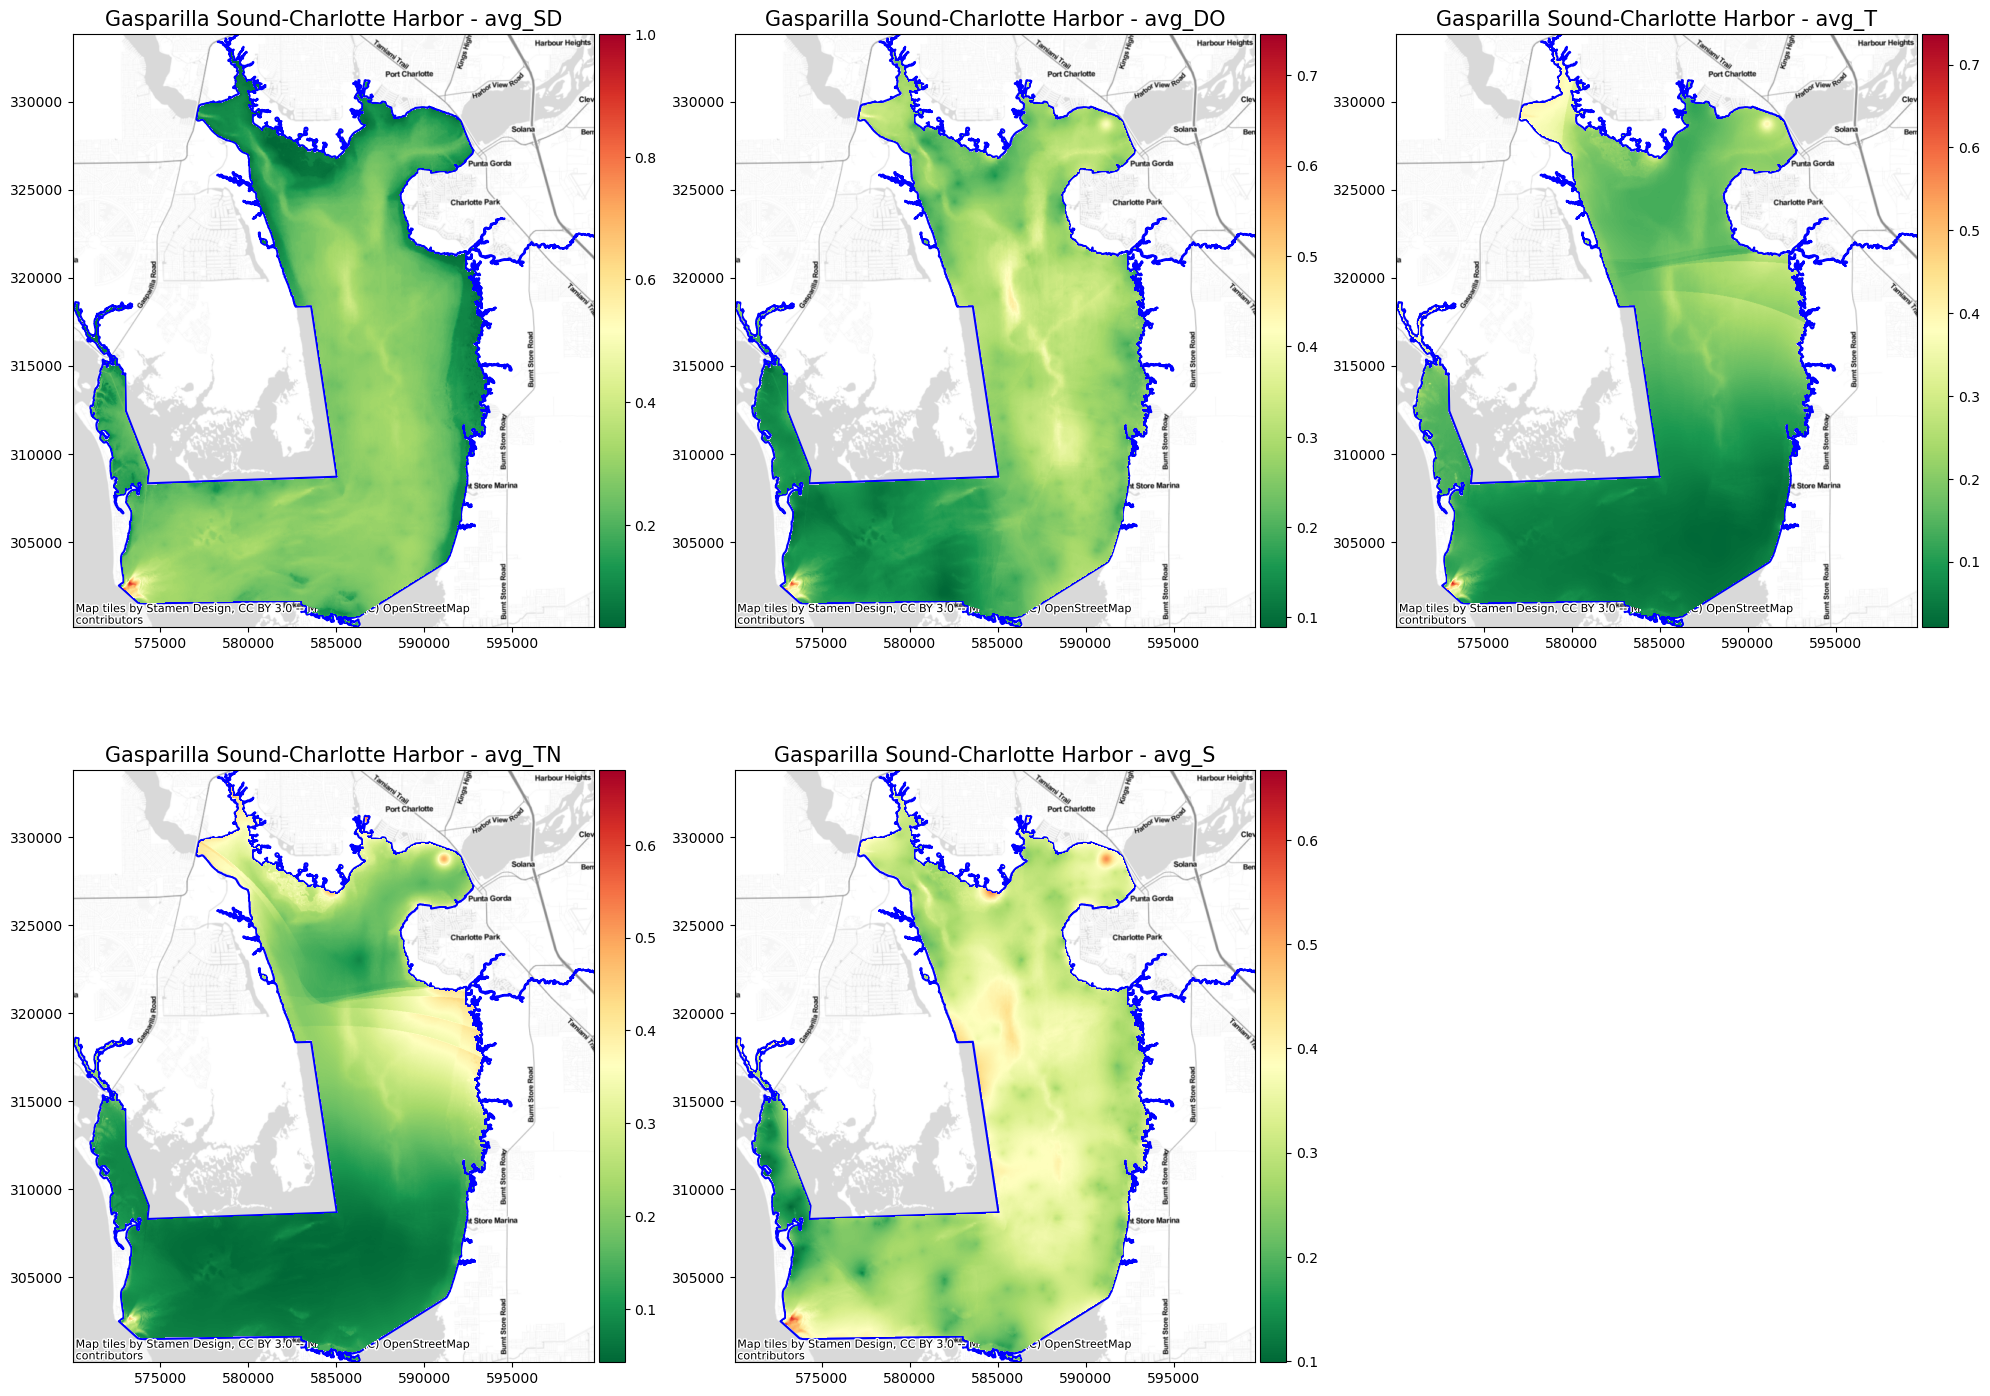

In [46]:
plot_tif_with_boundary(avg_tif_ch, boundary, 'Gasparilla Sound-Charlotte Harbor')

## 6.2 Estero Bay  <a class="anchor" id="reg_avg_rescale_sep_eb"></a>

In [47]:
# group_tif_by_shapes(rescale_Uppath_EB)

In [48]:
delete_all_files(avg_tif_eb)

There is no SD from 2015 to 2019.

In [49]:
calculate_average_tif(rescale_Uppath_EB, avg_tif_eb)

Processing parameter: T
Found 15 files for parameter T
Processing parameter: DO
Found 15 files for parameter DO
Processing parameter: S
Found 11 files for parameter S
Processing parameter: TN
Found 15 files for parameter TN


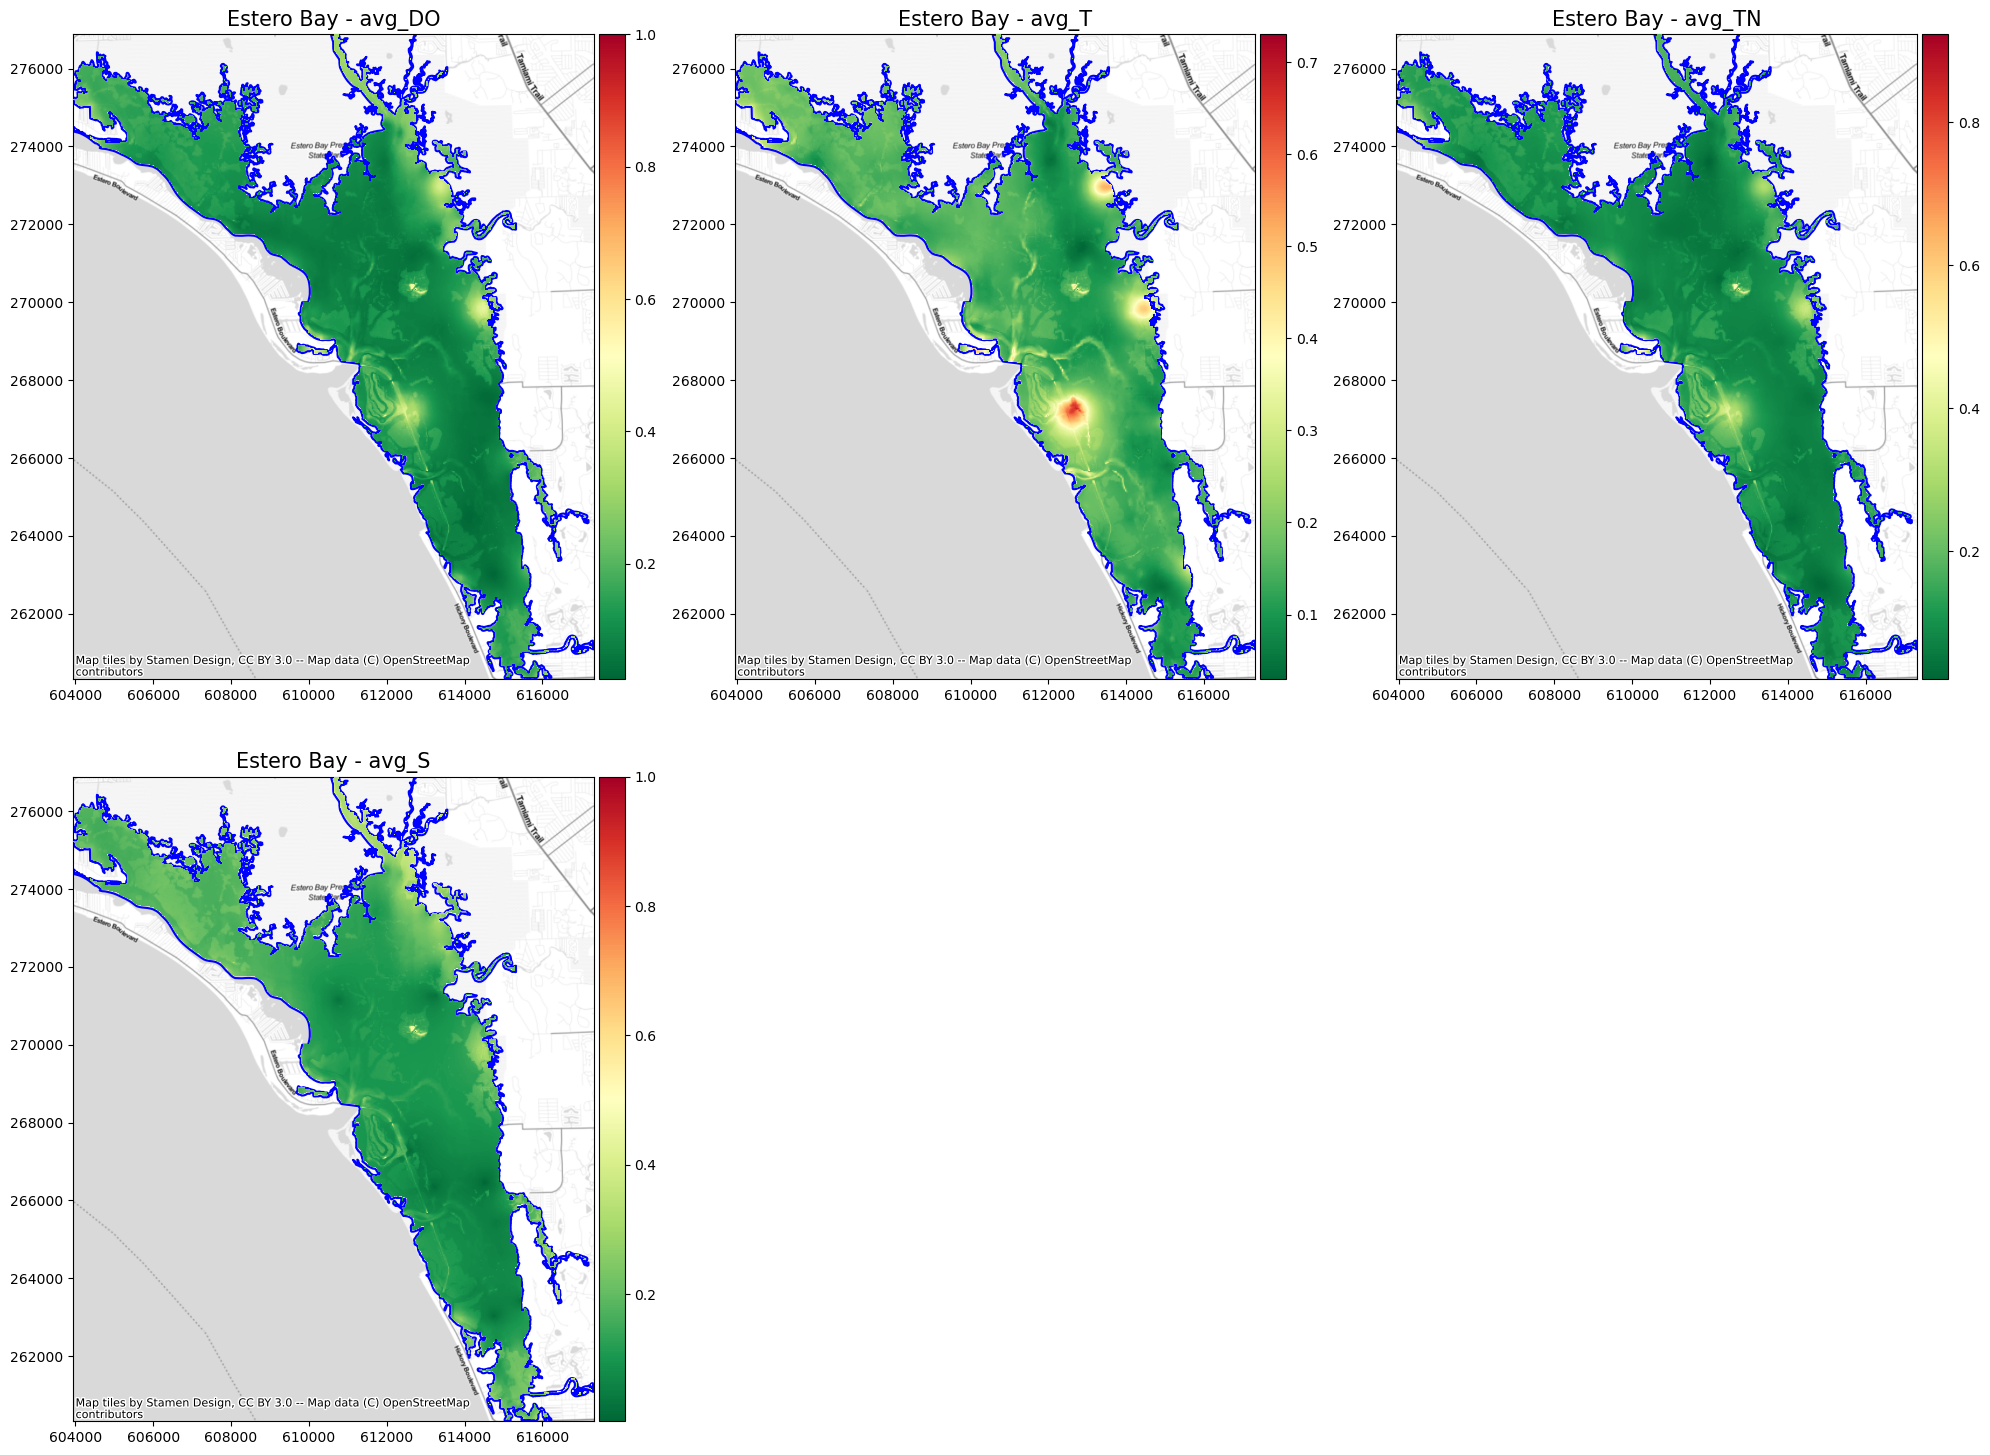

In [50]:
plot_tif_with_boundary(avg_tif_eb, boundary, 'Estero Bay')

##  6.3 Big Bend <a class="anchor" id="reg_avg_rescale_sep_bb"></a>

In [51]:
#group_tif_by_shapes(rescale_Uppath_BB)

In [52]:
delete_all_files(avg_tif_bb)

In [53]:
calculate_average_tif(rescale_Uppath_BB, avg_tif_bb)

Processing parameter: SD
Found 5 files for parameter SD
Processing parameter: T
Found 6 files for parameter T
Processing parameter: S
Found 8 files for parameter S
Processing parameter: TN
Found 8 files for parameter TN
Processing parameter: DO
Found 8 files for parameter DO


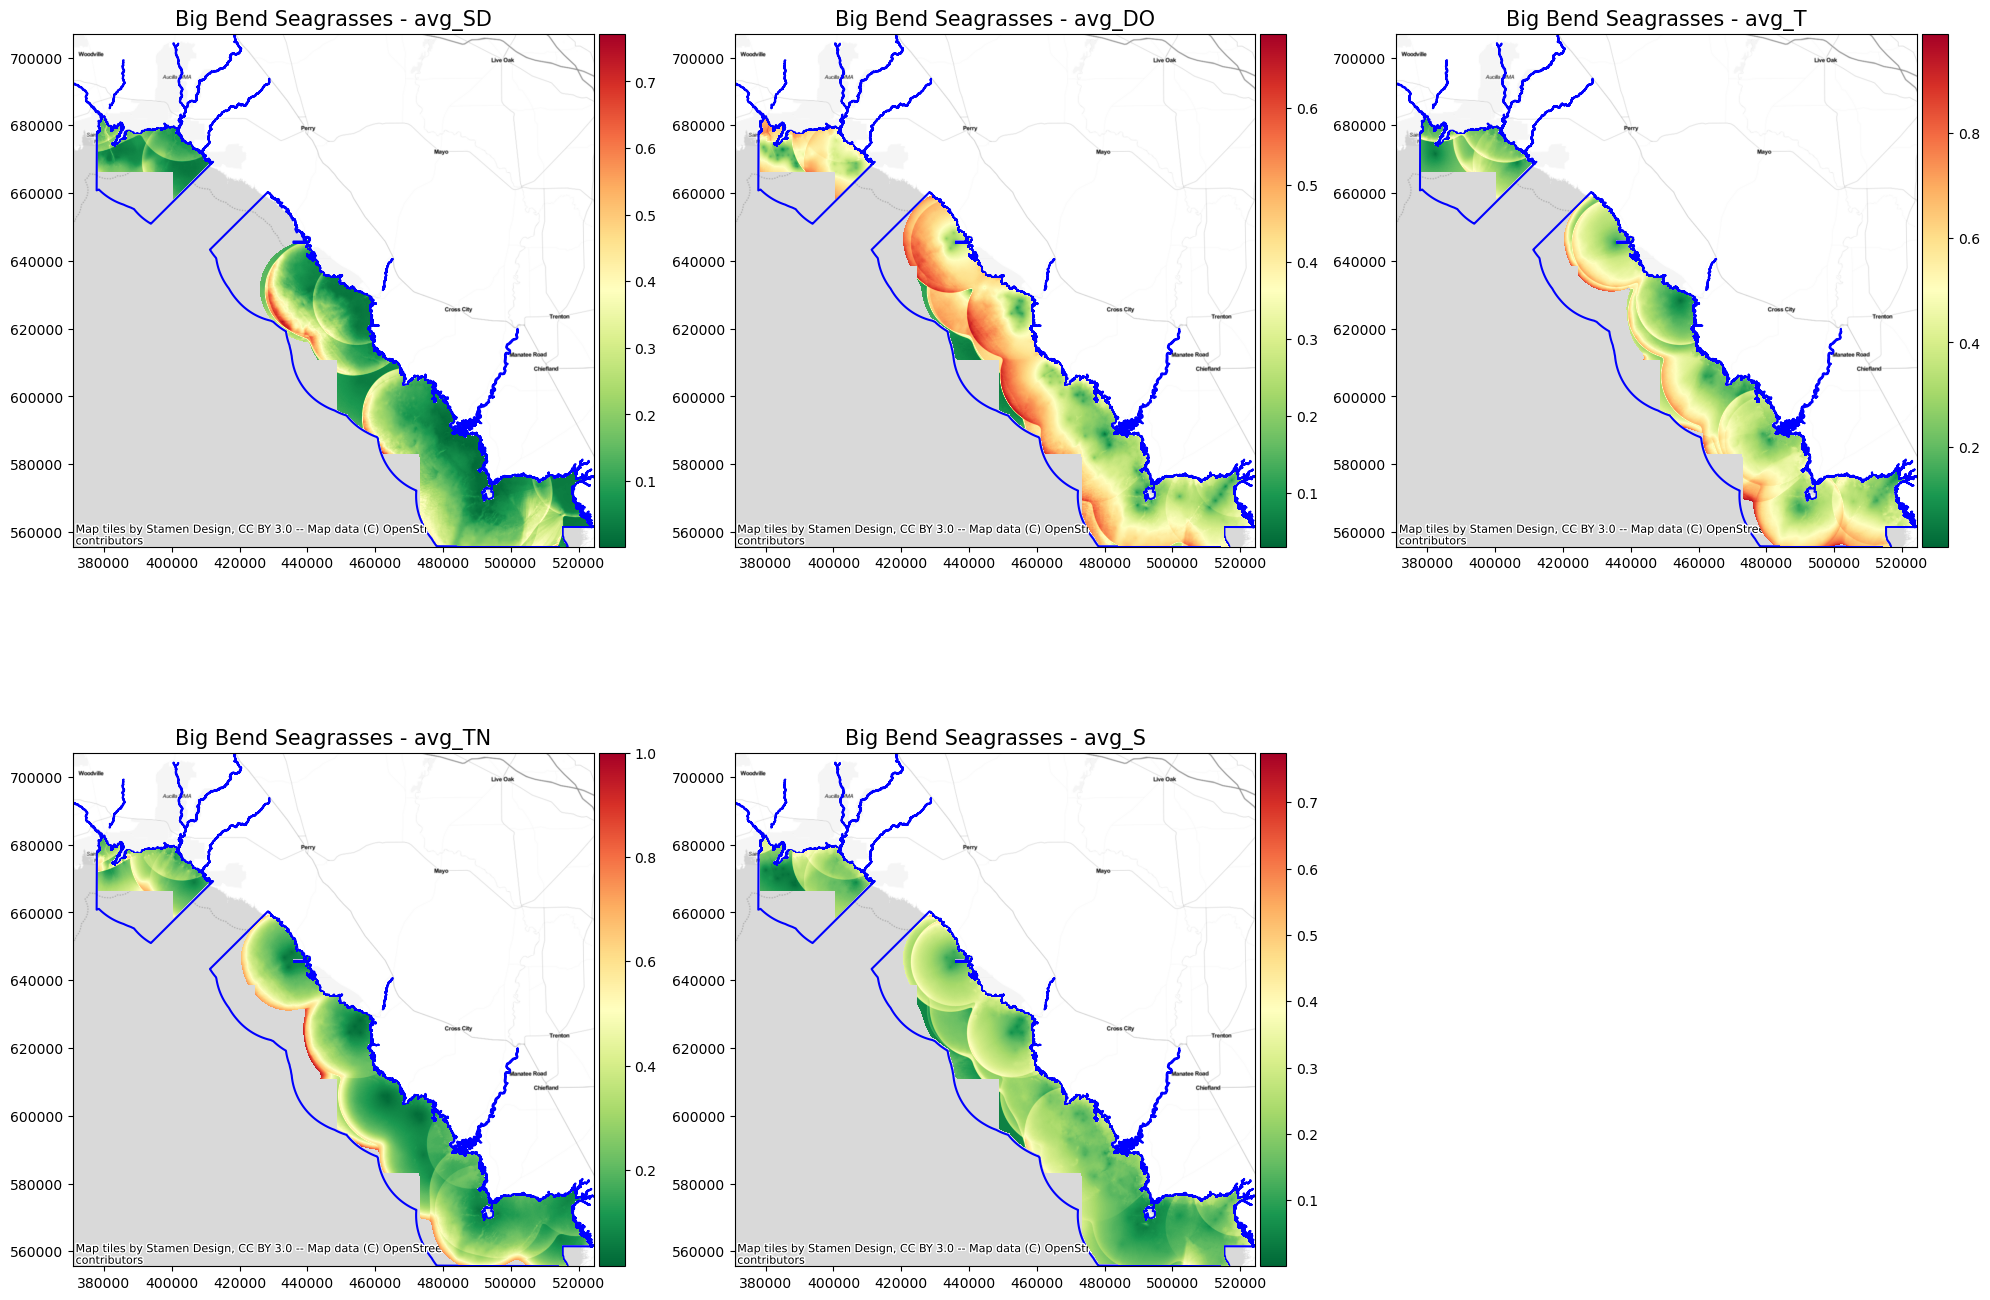

In [54]:
plot_tif_with_boundary(avg_tif_bb, boundary, 'Big Bend Seagrasses')

## 6.4 Biscayne Bay <a class="anchor" id="reg_avg_rescale_sep_bbay"></a>

In [55]:
# group_tif_by_shapes(rescale_Uppath_BBay)

In [56]:
delete_all_files(avg_tif_bbay)

In [57]:
calculate_average_tif(rescale_Uppath_BBay, avg_tif_bbay)

Processing parameter: SD
Found 3 files for parameter SD
Processing parameter: T
Found 3 files for parameter T
Processing parameter: S
Found 3 files for parameter S
Processing parameter: TN
Found 3 files for parameter TN
Processing parameter: DO
Found 3 files for parameter DO


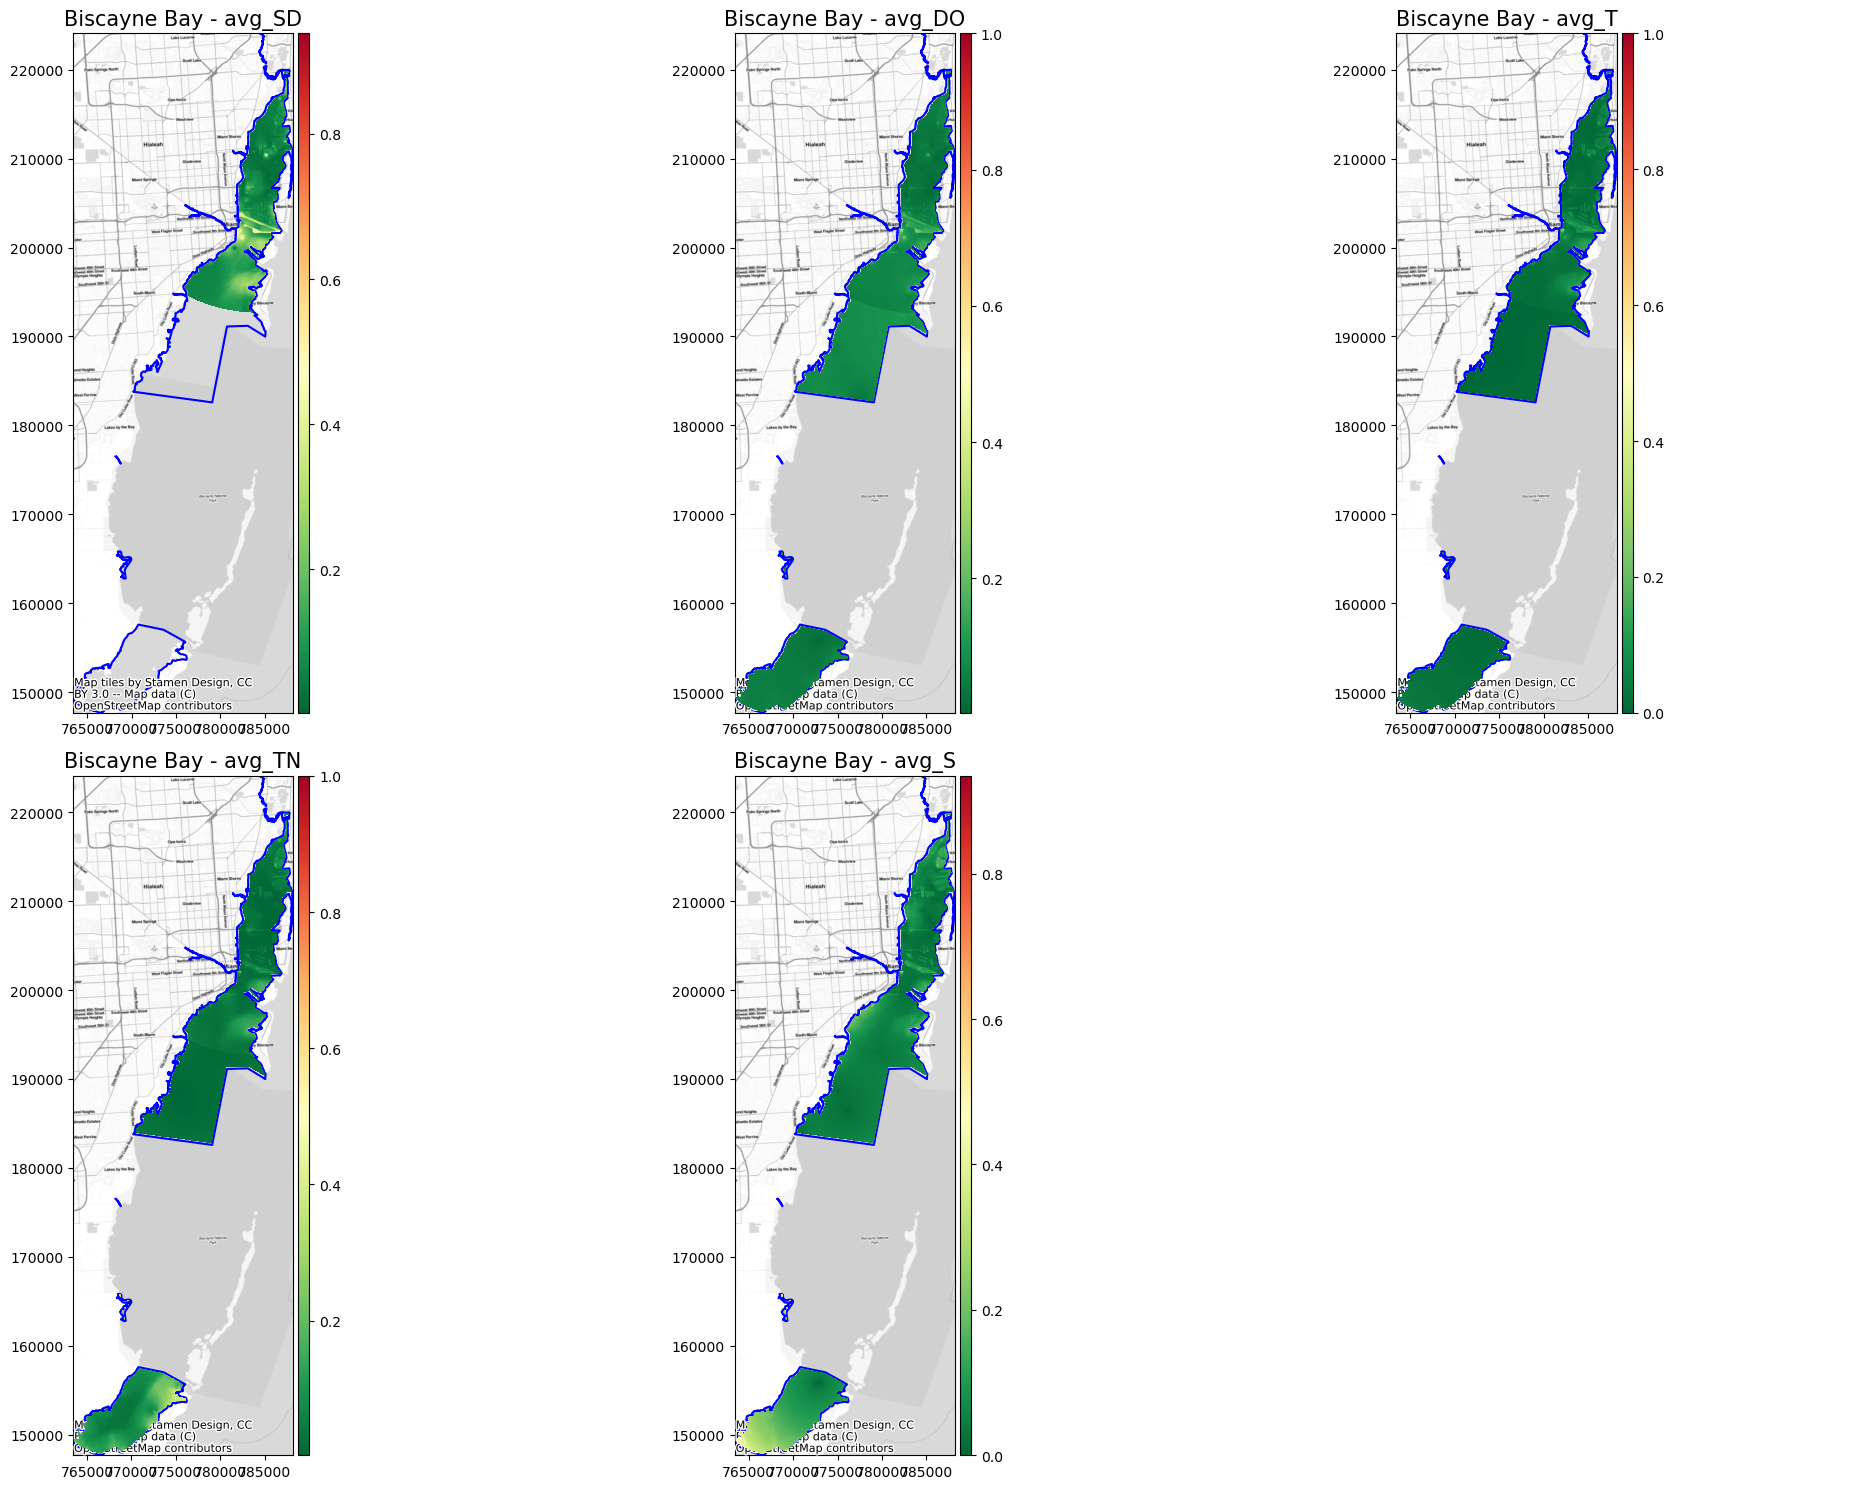

In [58]:
plot_tif_with_boundary(avg_tif_bbay, boundary, 'Biscayne Bay')

## 6.5 Guana Tolomato <a class="anchor" id="reg_avg_rescale_sep_gtm"></a>

In [59]:
# group_tif_by_shapes(rescale_Uppath_GTM)

In [60]:
delete_all_files(avg_tif_gtm)

In [61]:
calculate_average_tif(rescale_Uppath_GTM, avg_tif_gtm)

Processing parameter: T
Found 4 files for parameter T
Processing parameter: DO
Found 16 files for parameter DO
Processing parameter: S
Found 16 files for parameter S
Processing parameter: TN
Found 8 files for parameter TN


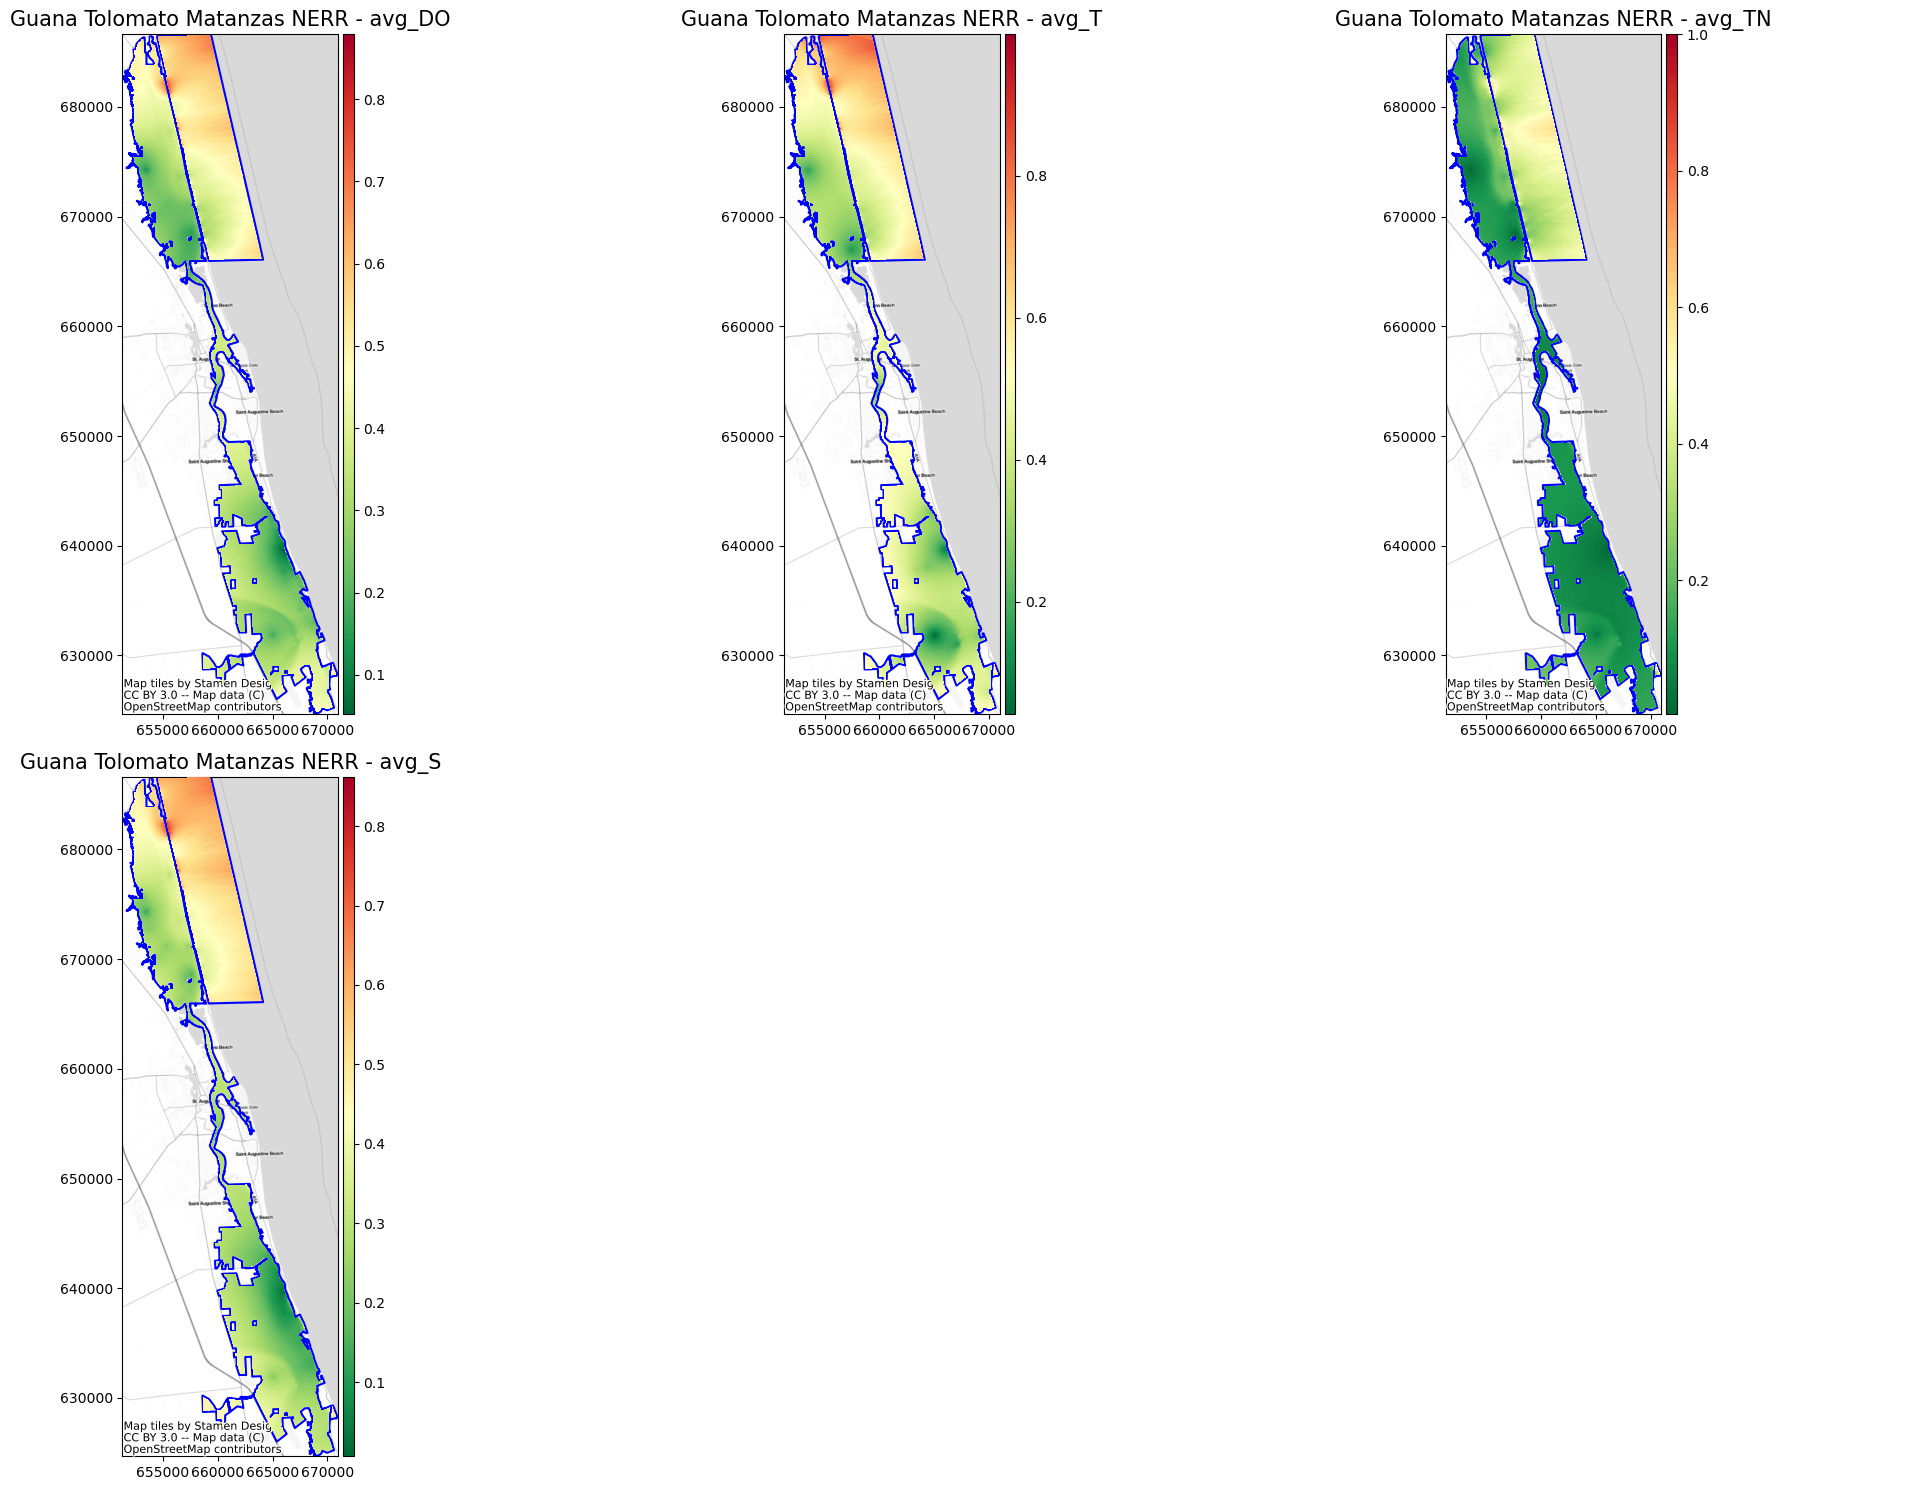

In [62]:
plot_tif_with_boundary(avg_tif_gtm, boundary, 'Guana Tolomato Matanzas NERR')

In [63]:
# def generate_season_table(df, year, region, season):
#     # Convert start and end dates to datetime objects
#     df['s_start'] = pd.to_datetime(df['s_start'])
#     df['s_end'] = pd.to_datetime(df['s_end'])

#     # Select data for the specified year, region, and season
#     df_selected = df[(df['st_Year'] == year) & (df['ma'] == region) & (df['season'] == season)]

#     # If no matching data is found, print a message and return
#     if df_selected.empty:
#         print('No matching data found.')
#         return

#     # Select the first row (assuming there is only one row of matching data)
#     row = df_selected.iloc[0]

#     # Print the start and end dates
#     print(f'The {season} of {year} in {region} starts on {row["s_start"].strftime("%Y-%m-%d")} and ends on {row["s_end"].strftime("%Y-%m-%d")}.')

# # Use the function, input DataFrame, year, region, and season
# generate_season_table(data, 2015, 'Gasparilla Sound-Charlotte Harbor Aquatic Preserve', 'Summer')

In [64]:
# SeasonTemp = path + r"OEATUSF_Geospatial_TempSeasons_corrected.csv"
# data = pd.read_csv(SeasonTemp)

In [65]:
# generate_season_table(data, 2015, 'Gasparilla Sound-Charlotte Harbor Aquatic Preserve', 'Summer')

Function to calculate average raster by season and parameter

# 7. Calculate Average Rescaled SEP by Season <a class="anchor" id="reg_calculate_average_season"></a>

In [66]:
def calculate_average_tif_season(folder_path, output_folder_path):
    # Get all files in the directory
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.endswith('.tif')]

    # Get unique parameters and seasons
    parameters_seasons_files = defaultdict(list)
    seasons_years = defaultdict(lambda: defaultdict(set))  # A nested dictionary to store years for each season and parameter
    for f in all_files:
        basename_parts = os.path.basename(f).split('_')
        year_season = basename_parts[1]
        param = os.path.splitext(basename_parts[2])[0]
        season = year_season[4:]  # Extract season from year_season string
        year = year_season[:4]  # Extract year from year_season string
        seasons_years[season][param].add(year)
        parameters_seasons_files[(season, param)].append(f)

    image_count = 0  # Initialize a counter for the generated images

    for (season, param), param_files in parameters_seasons_files.items():
        num_files = len(param_files)

        # Read first file to get metadata
        with rasterio.open(param_files[0]) as src0:
            meta = src0.meta
            data_shape = src0.shape
            nodata = src0.nodata

        # Initialize sum data and count
        sum_data = ma.zeros(data_shape, dtype=np.float64)
        count = ma.zeros(data_shape, dtype=np.uint16)

        # Read and accumulate data
        for file in param_files:
            with rasterio.open(file) as src:
                # Check if data shape is consistent with the first file
                if src.shape != data_shape:
                    print(f"Skipping file {file} due to inconsistent shape.")
                    continue

                # Read data and adjust size if necessary
                data = src.read(1).astype(np.float64)

                # Mask nodata values
                if nodata is not None:
                    data = ma.masked_values(data, nodata)

                # Accumulate data and count valid values
                sum_data += data.filled(0)
                count += ~data.mask

        # Calculate average
        avg_data = ma.array(sum_data / count, mask=count==0)
        avg_data[count==0] = nodata

        # Update metadata for the output file
        meta.update(count=1, dtype='float64', nodata=nodata)

        # Write to file
        output_file = os.path.join(output_folder_path, f"avg_{season}_{param}.tif")
        with rasterio.open(output_file, 'w', **meta) as dst:
            dst.write(avg_data.data, 1)

        image_count += 1  # Increase the counter each time an image is generated

    # Print all seasons and their corresponding years
    for season, param_years in seasons_years.items():
        for param, years in param_years.items():
            print(f"Season: {season} for parameter: {param} - Found {len(parameters_seasons_files[(season, param)])} files, Years: {sorted(list(years))}")
    print(f"Total number of generated images: {image_count}")  # Print the total number of generated images

In [67]:
def plot_tif_with_boundary_sort(tif_folder_path, study_area_shp_path, study_area_name):
    # Load the shapefile
    shapefile = gpd.read_file(study_area_shp_path)
    
    # Ensure the shapefile is in the same CRS as the tif files
    shapefile = shapefile.to_crs("EPSG:3086")
    
    # Get the polygon that matches the input study_area_name
    polygon = shapefile[shapefile['MA_Name'] == study_area_name].geometry

    # Check each tif file
    tif_files = [f for f in os.listdir(tif_folder_path) if f.endswith('.tif')]
    
    # Sort files by parameter
    def get_parameter_from_filename(filename):
        return filename.split('_')[2]
    tif_files.sort(key=get_parameter_from_filename)

    nrows = (len(tif_files) + 2) // 3
    
    # Create subplots
    fig, ax = plt.subplots(nrows=nrows, ncols=3, figsize=(20, 30*nrows/4))
    ax = ax.flatten()

    # Adjust the spacing between subplots
    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    
    for i, tif_file in enumerate(tif_files):
        tif_path = os.path.join(tif_folder_path, tif_file)

        # Open the tif file
        with rasterio.open(tif_path) as src:
            
            # Read the data as a numpy array
            masked_data = src.read(1, masked=True)

            # Compute the extent of the data
            extent = rasterio.plot.plotting_extent(src)

            # Save the original frame setting
            frame_on = ax[i].get_frame_on()

            # Show the tif data with cmap and extent
            ax[i].imshow(masked_data, cmap='RdYlGn_r', extent=extent, origin='upper', zorder=5)
            
            # Show the polygon boundary
            polygon.boundary.plot(ax=ax[i], color='blue')

            # Restore the original frame setting
            ax[i].set_frame_on(frame_on)

            # Add basemap
            cx.add_basemap(ax=ax[i], source=cx.providers.Stamen.TonerLite, crs='EPSG:3086')

            # Create colorbar that matches the height of the plot
            divider = make_axes_locatable(ax[i])
            cax = divider.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(ax[i].images[0], cax=cax)

            # Set title
            ax[i].set_title(f"{study_area_name} - {tif_file[:-4]}", fontsize=15)

    # Remove unused subplots
    for j in range(i+1, len(ax)):
        fig.delaxes(ax[j])

    plt.tight_layout()
    plt.show()

## 7.1 Charlotte Harbor <a class="anchor" id="reg_avg_rescale_sep_season_ch"></a>

In [68]:
delete_all_files(avg_tif_ch_season)

In [69]:
calculate_average_tif_season(rescale_Uppath_CH, avg_tif_ch_season)

Season: Fall for parameter: SD - Found 4 files, Years: ['2015', '2016', '2017', '2019']
Season: Fall for parameter: S - Found 5 files, Years: ['2015', '2016', '2017', '2018', '2019']
Season: Fall for parameter: TN - Found 5 files, Years: ['2015', '2016', '2017', '2018', '2019']
Season: Fall for parameter: DO - Found 5 files, Years: ['2015', '2016', '2017', '2018', '2019']
Season: Fall for parameter: T - Found 5 files, Years: ['2015', '2016', '2017', '2018', '2019']
Season: Spring for parameter: S - Found 4 files, Years: ['2015', '2016', '2017', '2019']
Season: Spring for parameter: T - Found 5 files, Years: ['2015', '2016', '2017', '2018', '2019']
Season: Spring for parameter: SD - Found 3 files, Years: ['2015', '2016', '2017']
Season: Spring for parameter: DO - Found 3 files, Years: ['2015', '2016', '2017']
Season: Spring for parameter: TN - Found 5 files, Years: ['2015', '2016', '2017', '2018', '2019']
Season: Summer for parameter: T - Found 4 files, Years: ['2015', '2016', '2018', '

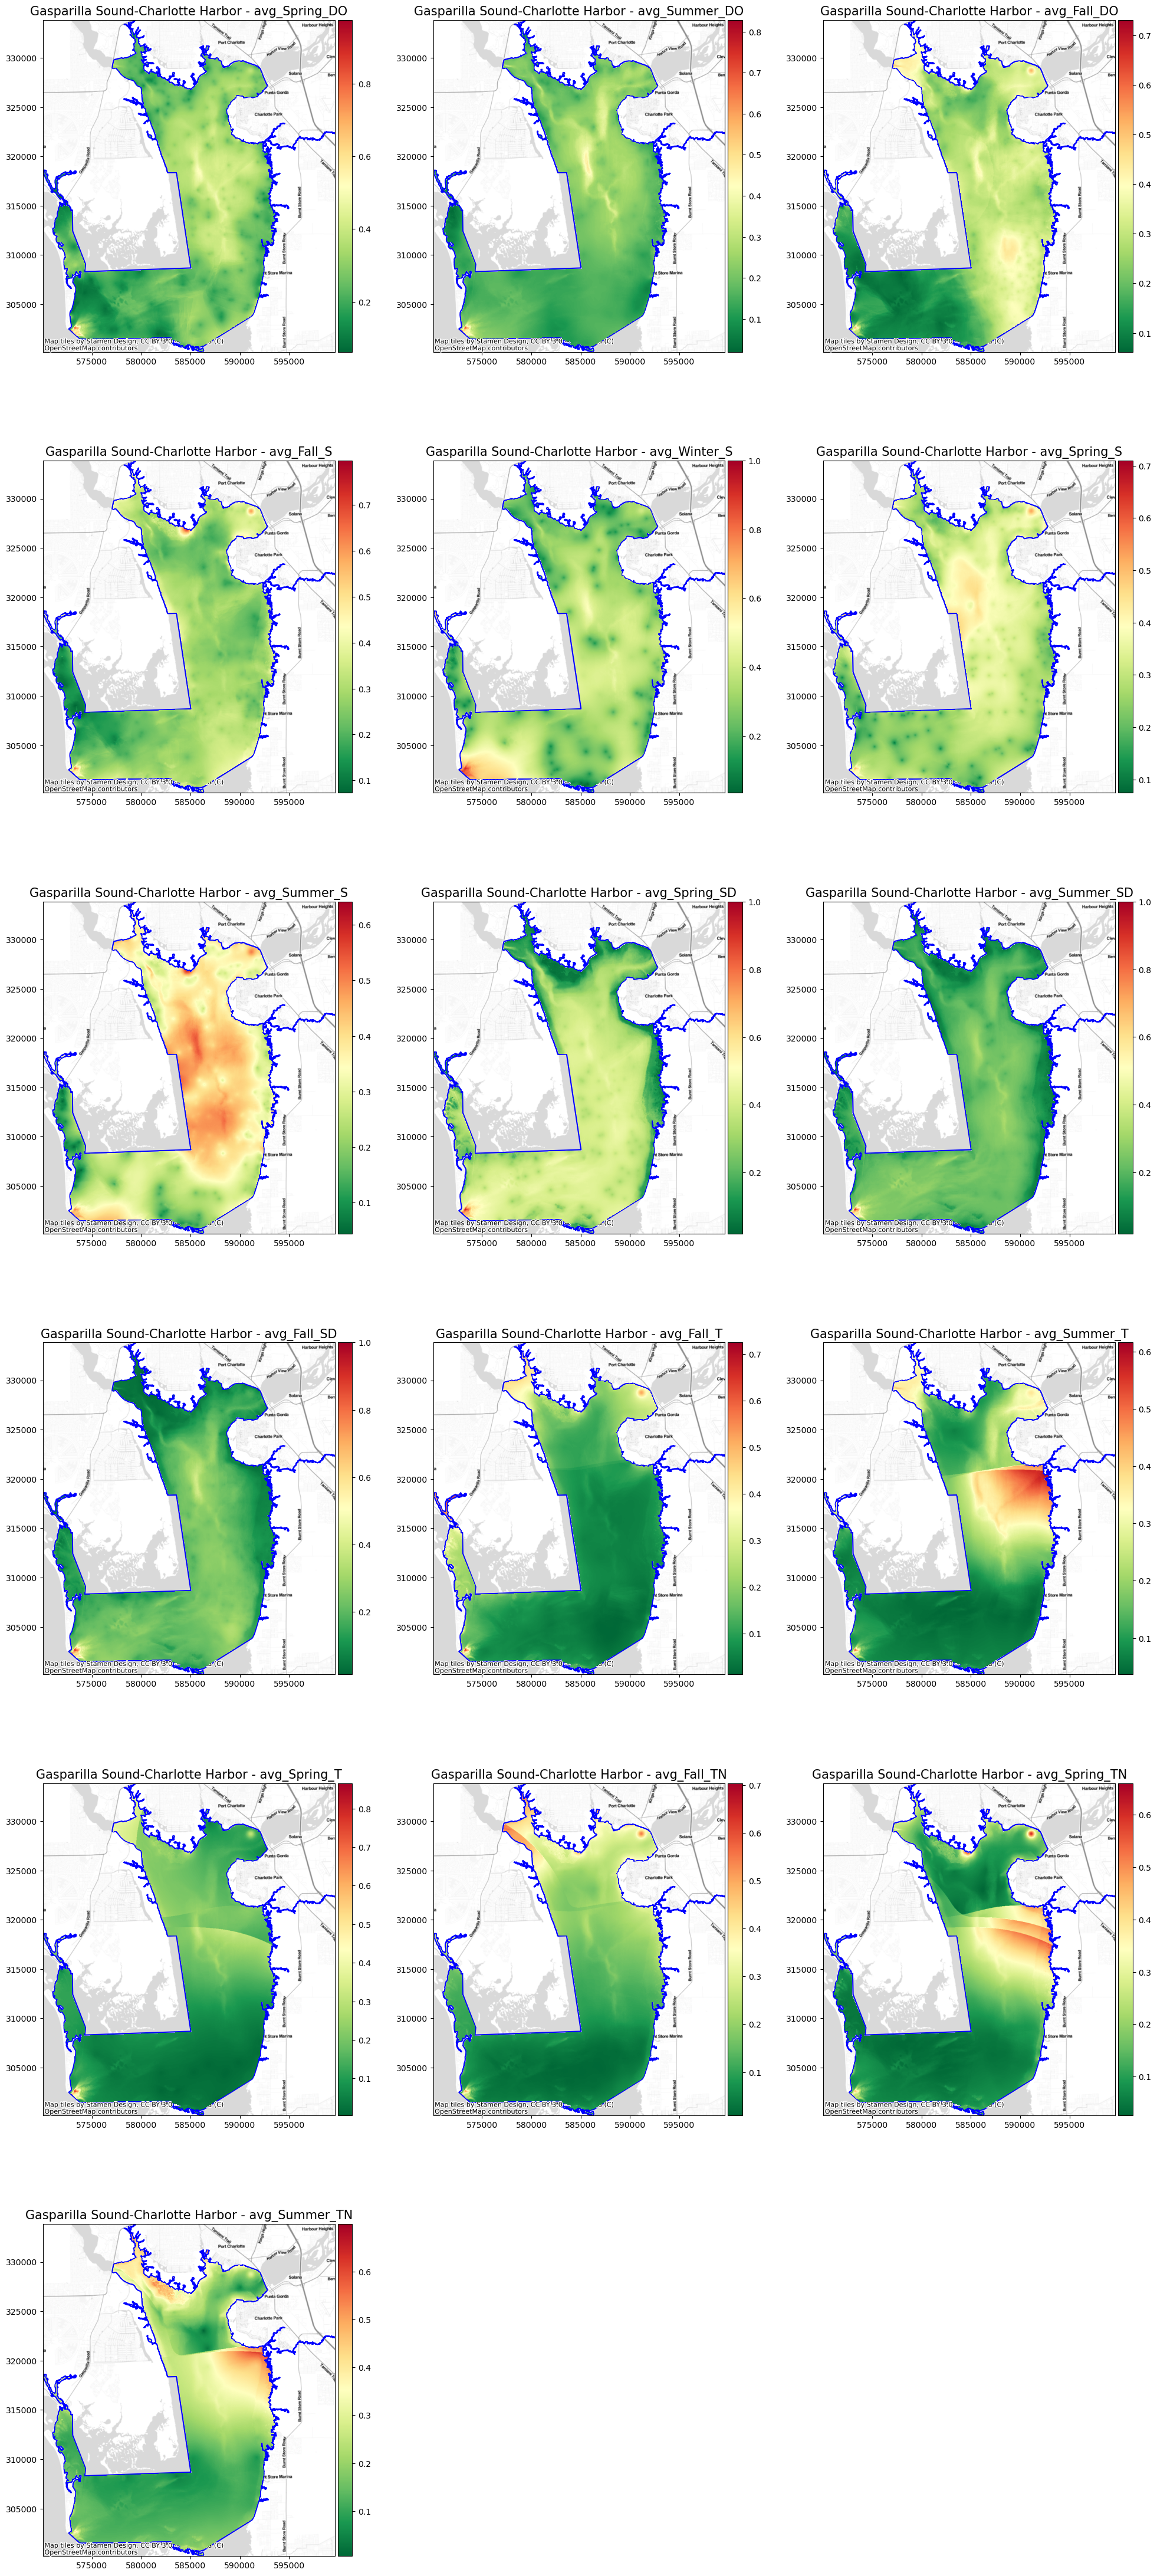

In [70]:
plot_tif_with_boundary_sort(avg_tif_ch_season, boundary, 'Gasparilla Sound-Charlotte Harbor')